# Chapter 8 Segmentation and Object Detection

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchmetrics

import os
from PIL import Image

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

import time

sns.set_theme(style="darkgrid", palette="pastel")
sns.set_context("notebook")

from utils import train_model

We will be segmenting cell nuclei using a dataset from the [2018 Data Science Bowl on Kaggle](https://www.kaggle.com/c/data-science-bowl-2018).  We've preprocessed the data so that the individual masks for each cell nucleus are combined into a single mask for all the nuclei in the image.  The images are also resized to 256x256 for simplicity.  The images and masks are stored in the data folder.  You can download a zipped copy of the dataset from Canvas for exploration.

## Dataset

The next cell shows our custom Dataset which loads an image and its mask from the specified root directory.  It also applies whatever torchvision transforms you specify to the image and its mask.  Take care if applying transforms that are random since they may not process the image and the mask the same way!

In [2]:
class DSB2018(Dataset):
    """Dataset class for the 2018 Data Science Bowl."""
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with 'images' and 'masks' subdirectories.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.images_dir = os.path.join(root_dir, 'images')
        self.masks_dir = os.path.join(root_dir, 'masks')
        
        self.image_names = [f for f in os.listdir(self.images_dir) if os.path.isfile(os.path.join(self.images_dir, f))]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.images_dir, self.image_names[idx])
        mask_name = os.path.join(self.masks_dir, 'mask_' + self.image_names[idx])

        image = Image.open(img_name).convert("RGB")
        mask = Image.open(mask_name).convert("L")  # Convert to grayscale to handle masks

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dsb_data = DSB2018(root_dir='./data', transform=transform)

# Example of loading an image and its mask
image, mask = dsb_data[0]  # Get the first sample

print(image.shape, mask.shape)  # Example of how to check the sizes


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


## Plot a sample image and mask

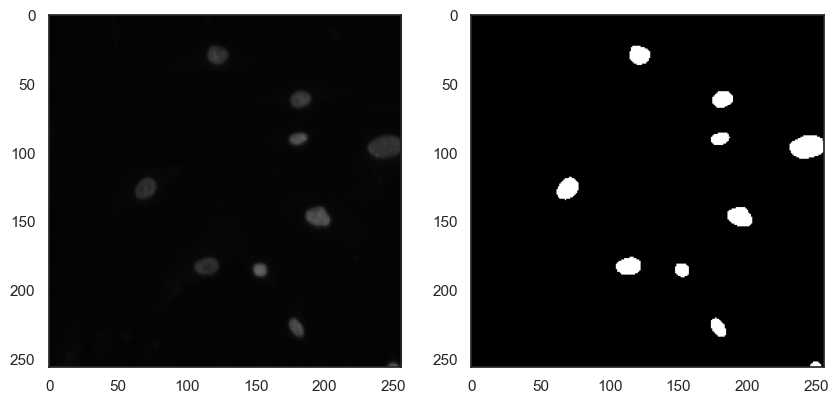

In [3]:
sns.set_theme(style='white')

plt.figure(figsize=(10,8))
#Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(dsb_data[0][0].permute(1,2,0).numpy());
#Plot the mask
plt.subplot(1, 2, 2)
plt.imshow(dsb_data[0][1].numpy()[0,:], cmap='gray');

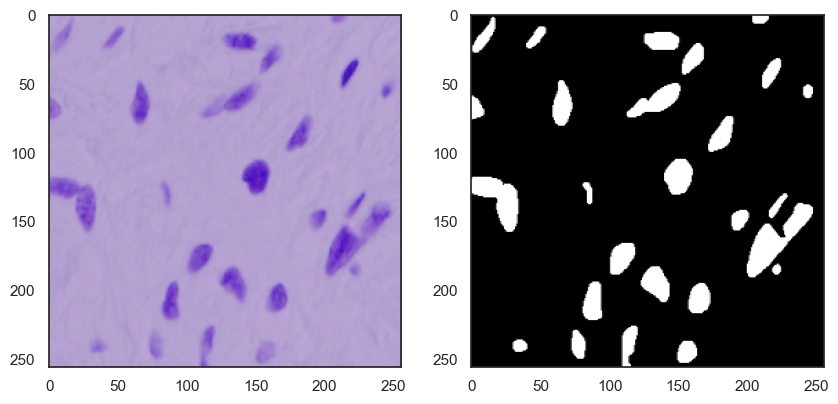

In [4]:
#Lets plot a second image that is in color
index = 10
plt.figure(figsize=(10,8))
plt.subplot(1, 2, 1)
plt.imshow(dsb_data[index][0].permute(1,2,0).numpy())
plt.subplot(1, 2, 2)
plt.imshow(dsb_data[index][1].numpy()[0,:], cmap='gray');

In [5]:
train_split, test_split = torch.utils.data.random_split(dsb_data, [500, len(dsb_data)-500])
train_seg_loader = DataLoader(train_split, batch_size=16, shuffle=True)
test_seg_loader = DataLoader(test_split,  batch_size=16)

In [6]:
C = 3 #How many channels are in the input? 
n_filters = 32 #Smallest value of filters you should usually consider. If we wanted to try and optimize the architecture we could use Optuna to pick a better number of filters. 
loss_func = nn.BCEWithLogitsLoss()#BCE loss implicitly assumes a binary problem

In [7]:
#Define our helper function that creates a hidden layer for a CNN
def cnnLayer(in_filters, out_filters, kernel_size=3):
    """
    in_filters: how many channels are in the input to this layer
    out_filters: how many channels should this layer output
    kernel_size: how large should the filters of this layer be
    """
    padding = kernel_size//2
    return nn.Sequential(
        nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding), 
        nn.BatchNorm2d(out_filters),
        nn.LeakyReLU(), # I'm not setting the leak value to anything just to make the code shorter. 
    )
#Specifying a model for image segmentation
segmentation_model = nn.Sequential(
    cnnLayer(C, n_filters), #First layer changes number of channels up to the large numer
    *[cnnLayer(n_filters, n_filters) for _ in range(5)], #Create 5 more hidden layers
    #Make a prediction for _every_ location. Notice we use 1 channel out, since we have a binary problem and are using BCEWithLogitsLoss as our loss function. 
    nn.Conv2d(n_filters, 1, (3,3), padding=1), #Shape is now (1, W, H)
)
#train the segmentation model
seg_results = train_model(segmentation_model, loss_func,
                          train_loader = train_seg_loader,
                          val_loader = test_seg_loader,
                          epochs = 15
                         )              

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 15/15, Training 100.00% complete, Validation 100.00% complete lr = 1.000e-03
 Epoch  train_loss  val_loss      Time    LR
    11    0.113294  0.108452 10.359764 0.001
    12    0.111733  0.097803 10.299416 0.001
    13    0.114521  0.128559 10.249393 0.001
    14    0.109307  0.114962 10.254819 0.001
    15    0.105942  0.094763 10.301859 0.001


In [ ]:
#plot an image, mask, and predicted mask



def plot_three(model, index):

    with torch.no_grad():# If we aren't training, so no gradients please!
        #push a test datapoint through the model. Remember the raw outputs are called the logits
        logits = model(test_split[index][0].unsqueeze(0))[0].cpu()
        #apply $\sigma$ to the logits to make predictions and then apply a threshold to get a prediction mask
        pred = torch.sigmoid(logits) >= 0.5
    
    #Plot the input, ground truth, and prediction
    plt.figure(figsize=(16,10))
    plt.subplot(1, 3, 1)
    plt.imshow(test_split[index][0].permute(1,2,0).numpy(), cmap='gray') #First plot the original input to the network
    plt.subplot(1, 3, 2)
    plt.imshow(test_split[index][1].numpy()[0,:], cmap='gray') #Second is ground truth
    plt.subplot(1, 3, 3) 
    plt.imshow(pred.numpy()[0,:], cmap='gray') #Third is the prediction our network made

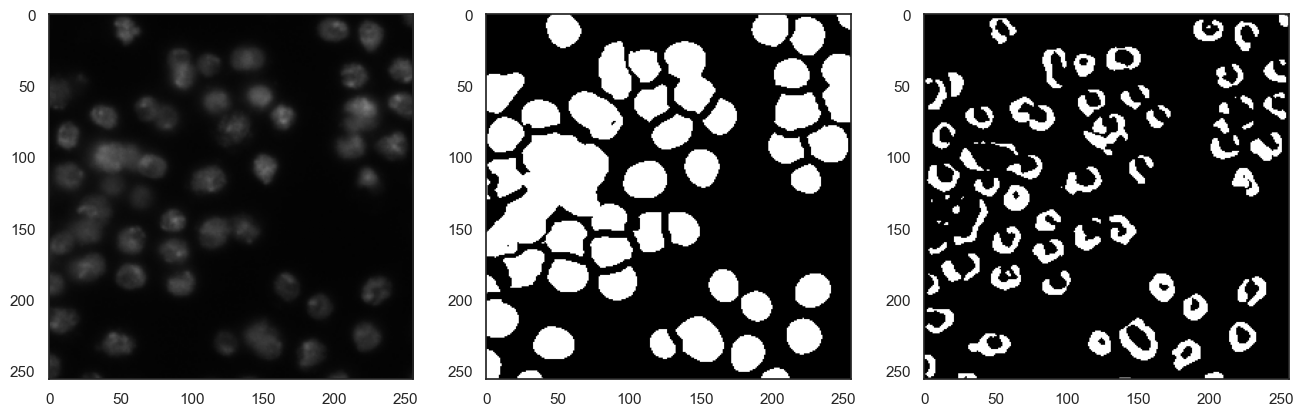

In [36]:
index = 10 # Change this to look at other entries from the dataset.
plot_three(segmentation_model, index)

In [9]:
segmentation_model2 = nn.Sequential(
    cnnLayer(C, n_filters), #First layer changes number of channels up to the large numer
    cnnLayer(n_filters, n_filters),
    nn.MaxPool2d(2), #Shrinks the height and width by 2
    cnnLayer(n_filters, 2*n_filters),
    cnnLayer(2*n_filters, 2*n_filters),
    cnnLayer(2*n_filters, 2*n_filters),
    #Double the height and width, countering the effect of the single MaxPool2d before
    nn.ConvTranspose2d(2*n_filters, n_filters, (3,3), padding=1, output_padding=1, stride=2),
    nn.BatchNorm2d(n_filters),
    nn.LeakyReLU(),
    #Back to normal convolutions
    cnnLayer(n_filters, n_filters),
    #Prediction for _every_ location
    nn.Conv2d(n_filters, 1, (3,3), padding=1), #Shape is now (B, 1, W, H)
)

#train the segmentation model
seg_results2 = train_model(segmentation_model2, loss_func,
                          train_loader = train_seg_loader,
                          val_loader = test_seg_loader,
                          epochs = 15
                         )       

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 15/15, Training 100.00% complete, Validation 100.00% complete lr = 1.000e-03
 Epoch  train_loss  val_loss     Time    LR
    11    0.111109  0.112347 9.514361 0.001
    12    0.104726  0.104471 9.541431 0.001
    13    0.100051  0.099603 9.552147 0.001
    14    0.099829  0.101314 9.545090 0.001
    15    0.095041  0.095721 9.521332 0.001


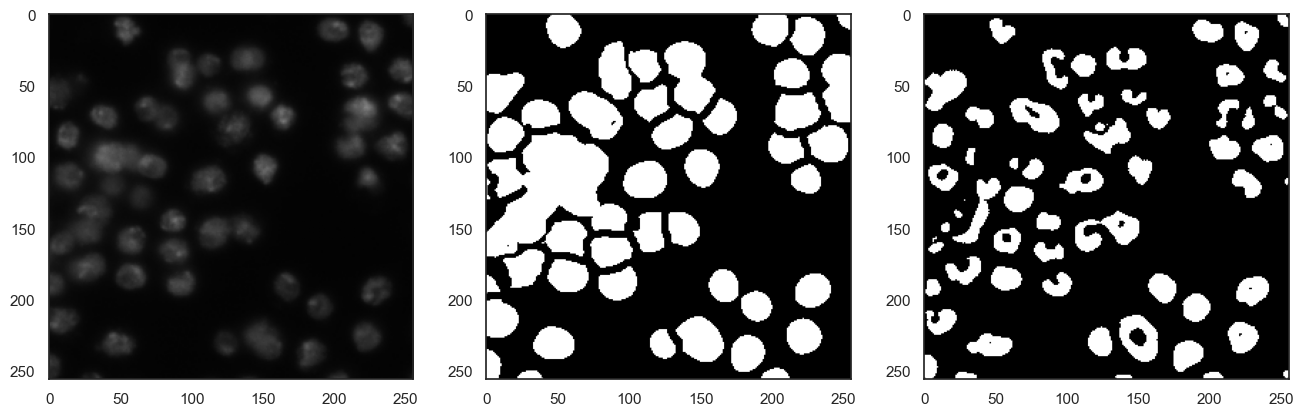

In [38]:
#plot an image, mask, and predicted mask

index = 10 # Change this to look at other entries from the dataset.
plot_three(segmentation_model2, index)

<Axes: xlabel='Epoch', ylabel='val_loss'>

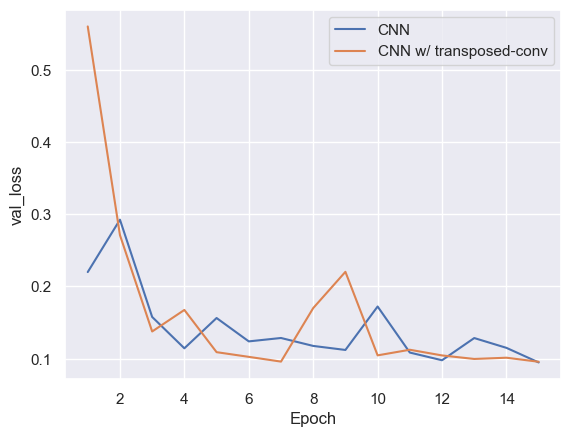

In [11]:
sns.set_theme(style='darkgrid')
sns.lineplot(x='Epoch', y='val_loss', data=seg_results, label='CNN')
sns.lineplot(x='Epoch', y='val_loss', data=seg_results2, label='CNN w/ transposed-conv')

In [12]:
class UNetBlock2d(nn.Module): #Our class extends nn.Module, all PyTorch layers must extend this 
    def __init__(self, in_channels, mid_channels, out_channels=None, layers=1, sub_network=None, filter_size=3):
        """ 
        in_channels: the number of channels in the input to this block
        mid_channels: the number of channels to have as the output for each convolutional filter
        out_channels: if not `None`, ends the network with a 1x1 convolution to convert the number of output channels to a specific number. 
        layers: how many blocks of hidden layers to create on both the input and output side of a U-Net block
        sub_network: the network to apply after shrinking the input by a factor of 2 using max pooling. The number of output channels should be equal to `mid_channels`
        filter_size: how large the convolutional filters should be
        """
        super().__init__()
        
        #Start preparing the layers used to process the input
        in_layers = [cnnLayer(in_channels, mid_channels, filter_size)]
        
        #If we have a sub-network, we will double the number of inputs to the output. So lets figure that out now
        if sub_network is None:
            inputs_to_outputs = 1
        else:
            inputs_to_outputs = 2

        #Preparing the layers used to make the final output, which has extra input channels from any sub-network
        out_layers = [ cnnLayer(mid_channels*inputs_to_outputs, mid_channels, filter_size)]
        
        #Make the additional hidden layers used for the input and output
        for _ in range(layers-1):
            in_layers.append(cnnLayer(mid_channels, mid_channels, filter_size))
            out_layers.append(cnnLayer(mid_channels, mid_channels, filter_size))
        #Use 1x1 Convolutions to ensure a specific output size
        if out_channels is not None:
            out_layers.append(nn.Conv2d(mid_channels, out_channels, 1, padding=0))
    
        #define our three total sub-networks:
        #1) in_model performs the intial rounds of convolution
        self.in_model = nn.Sequential(*in_layers)
        #2) our subnetwork works on the max-pooled result. We will add the pooling and up-scaling directly into the sub-model
        if sub_network is not None:
            self.bottleneck = nn.Sequential(
                nn.MaxPool2d(2), #Shrink
                sub_network, #process the smaller resolution
                #expand back up
                nn.ConvTranspose2d(mid_channels, mid_channels, filter_size, padding=filter_size//2, output_padding=1, stride=2)
            )
        else:
            self.bottleneck = None
        #3) the output model that processes the concatinated result, or just the output from in_model if no sub-network was given
        self.out_model = nn.Sequential(*out_layers)
        
    
    #The forward function is the code that takes an input and produce an output. 
    def forward(self, x):
        #compute the convolutions at the current scale
        full_scale_result = self.in_model(x) #(B, C, W, H)
        #check if we have a bottleneck to apply
        if self.bottleneck is not None:
            #(B, C, W, H) shape because bottleneck does both the pooling & expansion
            bottle_result = self.bottleneck(full_scale_result)
            #Now shape (B, 2*C, W, H)
            full_scale_result = torch.cat([full_scale_result, bottle_result], dim=1)
        #compute the output on the concatenated (or not!) result
        return self.out_model(full_scale_result)
#Caption: A class implementing a “Block” of the U-Net approach. Each block needs to know how many channels are coming in and out of the block. The block has three components. 1) the input network, what processes the raw input coming into this block. 2) the bottleneck, which is what the block runs after shrinking the current results down by a factor of 2, and then expands the result back up to the original size. 3) the output network, which is run on the results from the prior two sub-networks concatenated together. 

In [13]:
unet_model = nn.Sequential(
    UNetBlock2d(3, 32, layers=2, sub_network=
        UNetBlock2d(32, 64, out_channels=32, layers=2, sub_network=
            UNetBlock2d(64, 128, out_channels=64, layers=2)
        ),
    ),
    #Prediction for _every_ location
    nn.Conv2d(32, 1, (3,3), padding=1), #Shape is now (B, 1, W, H)
)

#train the segmentation model
unet_results = train_model(unet_model, loss_func,
                          train_loader = train_seg_loader,
                          val_loader = test_seg_loader,
                          epochs = 15
                         )       

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 15/15, Training 100.00% complete, Validation 100.00% complete lr = 1.000e-03
 Epoch  train_loss  val_loss      Time    LR
    11    0.074189  0.073831 17.321276 0.001
    12    0.072464  0.077578 17.284618 0.001
    13    0.070533  0.077627 17.299797 0.001
    14    0.070230  0.075445 17.337558 0.001
    15    0.068789  0.081599 17.419246 0.001


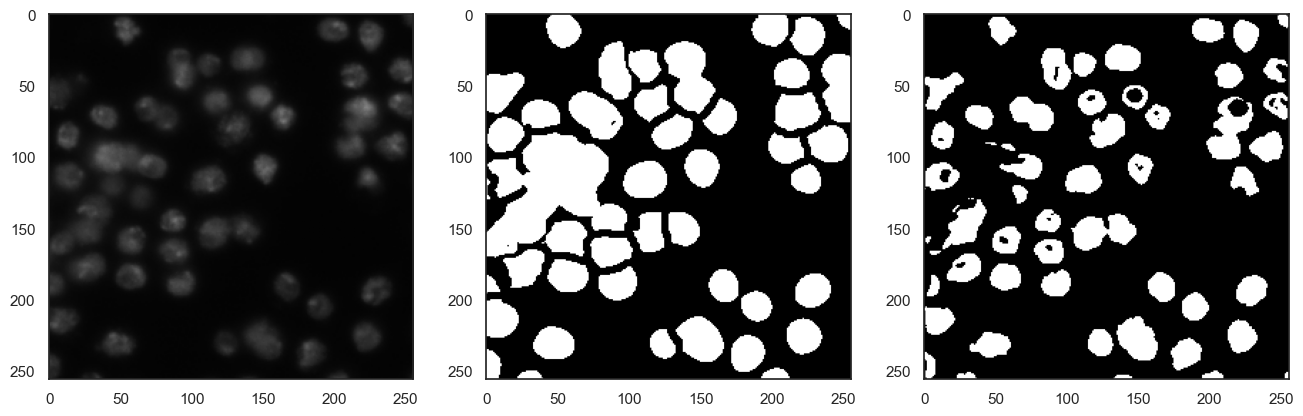

In [39]:
sns.set_theme(style='white')
index = 10 # Same example from before
plot_three(unet_model,index)

<Axes: xlabel='Epoch', ylabel='val_loss'>

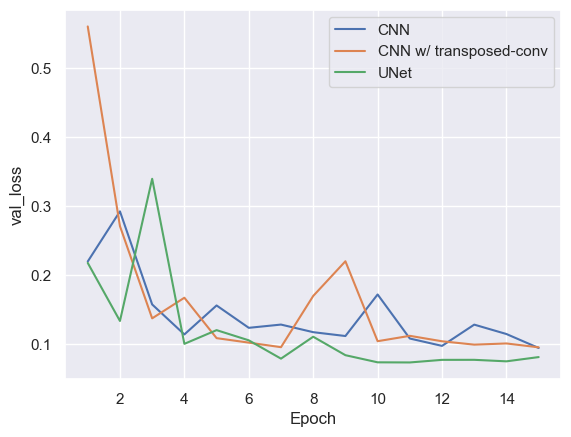

In [15]:
sns.set_theme(style='darkgrid')
sns.lineplot(x='Epoch', y='val_loss', data=seg_results, label='CNN')
sns.lineplot(x='Epoch', y='val_loss', data=seg_results2, label='CNN w/ transposed-conv')
sns.lineplot(x='Epoch', y='val_loss', data=unet_results, label='UNet')

### Attention U-Net

We won't go into detail on this one, but it was developed for biomedical image segmentation.  This implementation comes from https://www.kaggle.com/code/abhiswain/unet-pytorchlightning.  Attention is used in the upsampling part of the U-Net to scale the features from the downsampling path passed through the skip connections.  This helps the model better localize and focus on the important features for segmentation. 

In [16]:
class DoubleConv(nn.Module):
    def __init__(self, c_in, c_out):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=c_out, out_channels=c_out, kernel_size=3),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class DoubleConvSame(nn.Module):
    def __init__(self, c_in, c_out):
        super(DoubleConvSame, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=c_out, out_channels=c_out, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class AttentionBlock(nn.Module):
    """
    Class for creating Attention module
    Takes in gating signal `g` and `x`
    """

    def __init__(self, g_chl, x_chl):
        super(AttentionBlock, self).__init__()

        inter_shape = x_chl // 4

        # Conv 1x1 with stride 2 for `x`
        self.conv_x = nn.Conv2d(
            in_channels=x_chl,
            out_channels=inter_shape,
            kernel_size=1,
            stride=2,
        )

        # Conv 1x1 with stride 1 for `g` (gating signal)
        self.conv_g = nn.Conv2d(
            in_channels=g_chl,
            out_channels=inter_shape,
            kernel_size=1,
            stride=1,
        )

        # Conv 1x1 for `psi` the output after `g` + `x`
        self.psi = nn.Conv2d(
            in_channels=2 * inter_shape,
            out_channels=1,
            kernel_size=1,
            stride=1,
        )

        # For upsampling the attention output to size of `x`
        self.upsample = nn.Upsample(scale_factor=2)

    def forward(self, g, x):

        # perform the convs on `x` and `g`
        theta_x = self.conv_x(x)
        gate = self.conv_g(g)

        # `theta_x` + `gate`
        add = torch.cat([self.conv_x(x), self.conv_g(g)], axis=1)

        # ReLU on the add operation
        relu = torch.relu(add)

        # the 1x1 Conv
        psi = self.psi(relu)

        # Sigmoid the squash the outputs/attention weights
        sig = torch.sigmoid(psi)

        # Upsample to original size of `x` to perform multiplication
        upsample = self.upsample(sig)

        # return the attention weights!
        return upsample


class AttentionUNet(nn.Module):
    def __init__(self, c_in, c_out):
        super(AttentionUNet, self).__init__()

        self.conv1 = DoubleConvSame(c_in=c_in, c_out=64)
        self.conv2 = DoubleConvSame(c_in=64, c_out=128)
        self.conv3 = DoubleConvSame(c_in=128, c_out=256)
        self.conv4 = DoubleConvSame(c_in=256, c_out=512)
        self.conv5 = DoubleConvSame(c_in=512, c_out=1024)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.attn1 = AttentionBlock(1024, 512)
        self.attn2 = AttentionBlock(512, 256)
        self.attn3 = AttentionBlock(256, 128)
        self.attn4 = AttentionBlock(128, 64)

        self.up1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512, kernel_size=2, stride=2
        )
        self.up2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256, kernel_size=2, stride=2
        )
        self.up3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128, kernel_size=2, stride=2
        )
        self.up4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64, kernel_size=2, stride=2
        )

        self.up_conv1 = DoubleConvSame(c_in=1024, c_out=512)
        self.up_conv2 = DoubleConvSame(c_in=512, c_out=256)
        self.up_conv3 = DoubleConvSame(c_in=256, c_out=128)
        self.up_conv4 = DoubleConvSame(c_in=128, c_out=64)

        self.conv_1x1 = nn.Conv2d(in_channels=64, out_channels=c_out, kernel_size=1)

    def forward(self, x):
        """ENCODER"""

        c1 = self.conv1(x)
        p1 = self.pool(c1)

        c2 = self.conv2(p1)
        p2 = self.pool(c2)

        c3 = self.conv3(p2)
        p3 = self.pool(c3)

        c4 = self.conv4(p3)
        p4 = self.pool(c4)

        """BOTTLE-NECK"""

        c5 = self.conv5(p4)

        """DECODER - WITH ATTENTION"""

        att1 = self.attn1(c5, c4)
        u1 = self.up1(c5)
        mult1 = torch.multiply(att1, u1)
        cat1 = torch.cat([mult1, c4], dim=1)
        uc1 = self.up_conv1(cat1)

        att2 = self.attn2(uc1, c3)
        u2 = self.up2(uc1)
        mult2 = torch.multiply(att2, u2)
        cat2 = torch.cat([mult2, c3], dim=1)
        uc2 = self.up_conv2(cat2)

        att3 = self.attn3(uc2, c2)
        u3 = self.up3(uc2)
        mult3 = torch.multiply(att3, u3)
        cat3 = torch.cat([mult3, c2], dim=1)
        uc3 = self.up_conv3(cat3)

        att4 = self.attn4(uc3, c1)
        u4 = self.up4(uc3)
        mult4 = torch.multiply(att4, u4)
        cat4 = torch.cat([mult4, c1], dim=1)
        uc4 = self.up_conv4(cat4)

        outputs = self.conv_1x1(uc4)

        return outputs

### Training and Evaluating Attention U-Net

In [17]:
attn_unet_model = AttentionUNet(3,1)

#train the segmentation model
attn_unet_results = train_model(attn_unet_model, loss_func,
                          train_loader = train_seg_loader,
                          val_loader = test_seg_loader,
                          epochs = 15
                         )       

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 15/15, Training 100.00% complete, Validation 100.00% complete lr = 1.000e-03
 Epoch  train_loss  val_loss      Time    LR
    11    0.096258  0.090685 71.681717 0.001
    12    0.091504  0.091139 70.604933 0.001
    13    0.096814  0.092158 71.398300 0.001
    14    0.088832  0.100278 70.453228 0.001
    15    0.087837  0.090618 70.780608 0.001


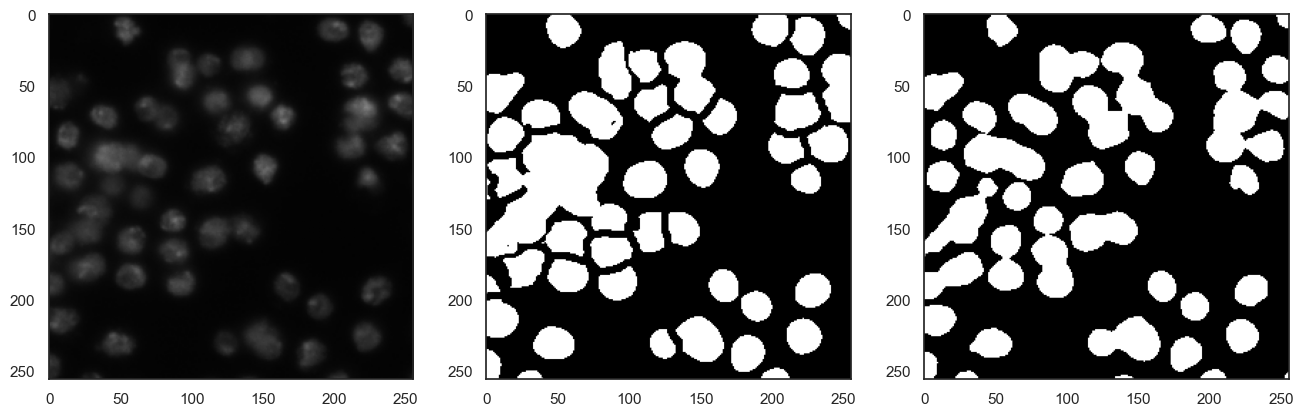

In [40]:
sns.set_theme(style='white')
index = 10 # Same example from before
plot_three(attn_unet_model,index)

<Axes: xlabel='Epoch', ylabel='val_loss'>

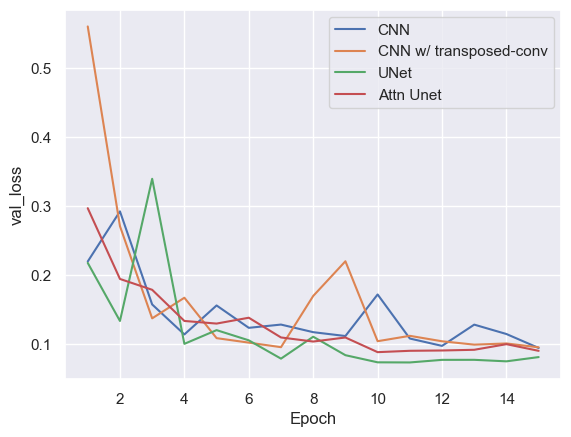

In [19]:
sns.set_theme(style='darkgrid')
sns.lineplot(x='Epoch', y='val_loss', data=seg_results, label='CNN')
sns.lineplot(x='Epoch', y='val_loss', data=seg_results2, label='CNN w/ transposed-conv')
sns.lineplot(x='Epoch', y='val_loss', data=unet_results, label='UNet')
sns.lineplot(x='Epoch', y='val_loss', data=attn_unet_results, label='Attn Unet')

*****************************************************************************************